In [1]:
from pathlib import Path
from course_intro_ocr_t1.data import MidvPackage
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np

In [2]:
DATASET_PATH = Path().absolute().parent.parent / 'midv500' / 'midv500_compressed'
assert DATASET_PATH.exists(), DATASET_PATH.absolute()

In [3]:
# Собираем список пакетов (MidvPackage) 
data_packs = MidvPackage.read_midv500_dataset(DATASET_PATH)
len(data_packs), type(data_packs[0])

(50, course_intro_ocr_t1.data.MidvPackage)

In [4]:
# В каждом пакете - 300 штук DataItem
dp = data_packs[0]
di = dp[220]
type(dp), len(dp), type(di)


(course_intro_ocr_t1.data.MidvPackage, 300, course_intro_ocr_t1.data.DataItem)

In [5]:
# DataItem содержит пути до файлов изображения и разметки
di.gt_path, di.img_path

(PosixPath('/Users/lex/Projects/MIPT/aot/task1/midv500/midv500_compressed/33_mac_id/ground_truth/KA/KA33_09.json'),
 PosixPath('/Users/lex/Projects/MIPT/aot/task1/midv500/midv500_compressed/33_mac_id/images/KA/KA33_09.tif'))

In [6]:
# в gt_data (данные json) quad в абсолютных значениях (пиксели)
np.array(di.gt_data['quad'])

array([[ 47, 255],
       [428, 269],
       [422, 506],
       [ 38, 494]])

[[0.10444444 0.31875   ]
 [0.95111111 0.33625   ]
 [0.93777778 0.6325    ]
 [0.08444444 0.6175    ]]


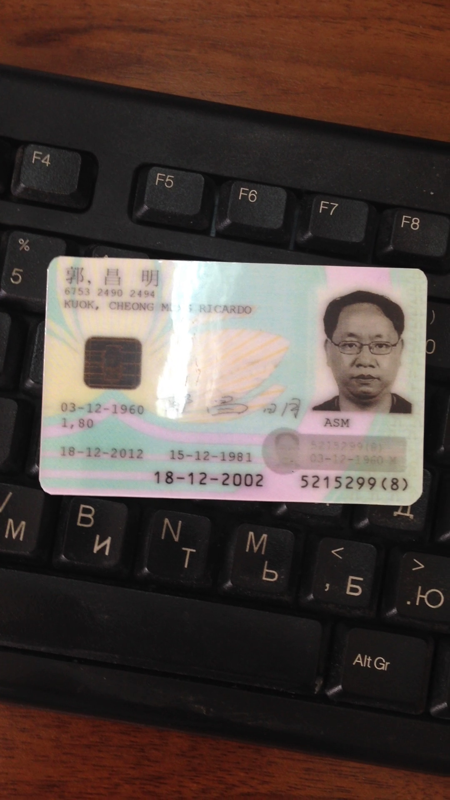

In [7]:
# Можно посмотреть изображения и разметку; в .quadrangle используются относительные единицы
print(di.quadrangle)
di.image

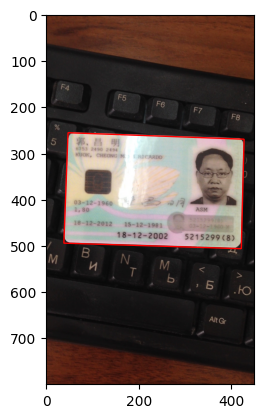

In [8]:
# Можно отрисовать разметку
# Не обязательно весь документ виден в кадре
di.show()

In [9]:
# DataItem содержит в себе информацию, относится ли он к test_split и целиком ли разметка внутри кадра
di.is_test_split(), di.is_quad_inside()

(False, True)

False


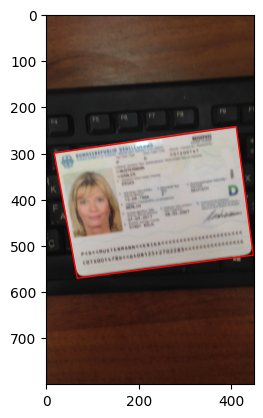

In [10]:
print(data_packs[38][238].is_test_split())
data_packs[38][238].show()

In [11]:
## Статистика, как часто разметка не целиком в кадре
is_quad_inside = []
for dp in tqdm(data_packs):
    for i in range(len(dp)):
        is_quad_inside.append(dp[i].is_quad_inside())
is_quad_inside = np.array(is_quad_inside).astype(int)
print(f"В {is_quad_inside.sum()} из {len(is_quad_inside)} случаев разметка кропа(т.е. документ) целиком в кадре")

100%|██████████| 50/50 [00:06<00:00,  8.17it/s]

В 9992 из 15000 случаев разметка кропа(т.е. документ) целиком в кадре


In [12]:
## Статистика test-split
is_test_split = []
for dp in tqdm(data_packs):
    for i in range(len(dp)):
        is_test_split.append(dp[i].is_test_split())
is_test_split = np.array(is_test_split).astype(int)
print(f"В {is_test_split.sum()} из {len(is_test_split)} случаев кадр принадлежит к test-split")

100%|██████████| 50/50 [00:00<00:00, 559.22it/s]

В 4250 из 15000 случаев кадр принадлежит к test-split


## Classic CV baseline

### Для работы baseline нужен установленныей OpenCV 

In [13]:
import cv2

In [14]:
class SimpleBaselineCrop:
    """
    Baseline на основе поиска и сопоставления ключевых точек на шаблоне(ref) и запросе(query)
    Алгоритм:
        0. Найти ключевые точки(КТ) на ref
        1. Найти ключевые точки(КТ) на query
        2. Сопоставить КТ query и ref друг-другу
        3. На основе сопоставления найти гомографию из ref в query
        4. Отобразить 4 угла изображения ref в query - это искомый четырехугольник кропа
    """
    def __init__(self, ref_image):
        self.ref_image = ref_image
        
        # 0. Найти ключевые точки(КТ) на ref
        self.ref_kpts, self.ref_fts = self.compute_kps(
            self.ref_image
        )

    def compute_kps(self, img, response_quantile=0.25):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        sift = cv2.SIFT_create()
        kp = sift.detect(gray, None)
        # фильтруем 25% неуверенных точек
        q_val = np.quantile(list(k.response for k in kp), response_quantile)
        kp = [k for k in kp if k.response > q_val]
        
        kp, features = sift.compute(gray, kp)
        return kp, features 
    
    def find_qr_homography(self, kp_q, ft_q, kp_r, ft_r, ratio=0.75):
        # 2. Сопоставить КТ query и ref друг-другу
        bf = cv2.BFMatcher()
        matches = bf.knnMatch(ft_q, ft_r, k=2)
        good = []

        # Дополнителный опциональный шаг - фильтрация Lowe, Lowe ratio-test:
        # Пусть есть лучший матч1 (query-kp, ref-kp)
        # Если есть другой возможный матч2 (query-kp, ref-kp2), и их качество
        # (т.е. расстояние в пространстве features) маленькое,
        # то нельзя быть уверенном, что матч1 - надежный, и проще его выбросить
        for m,n in matches:
            if m.distance <  ratio * n.distance:
                good.append([m])
                
        ptsA = np.zeros((len(good), 2), dtype="float")
        ptsB = np.zeros((len(good), 2), dtype="float")

        for (i, mlist) in enumerate(good):
            m = mlist[0]
            ptsA[i] = kp_q[m.queryIdx].pt
            ptsB[i] = kp_r[m.trainIdx].pt
        # 3. На основе сопоставления найти гомографию из ref в query
        (H, mask) = cv2.findHomography(ptsB, ptsA, method=cv2.RANSAC)
        return H
              
    def compute_crop(self, ref_img, hmg):
        # 4. Отобразить 4 угла изображения ref в query - это искомый четырехугольник кропа
        h, w, _ = ref_img.shape
        h = float(h)
        w = float(w)
        points = [
            [0, 0],
            [w, 0],
            [w, h],
            [0, h],
        ]
        points_crop = []
        for p in points:
            # применяем гомографию к точке, представленной в гомогенных координатах
            vec = hmg @ np.array([p[0], p[1], 1])
            points_crop.append([vec[0]/vec[-1], vec[1]/vec[-1]])
        return np.array(points_crop)
        
    def __call__(self, query_image):
        # 1. Найти ключевые точки(КТ) на query
        kpts, fts = self.compute_kps(query_image)
        
        homography = self.find_qr_homography(
            kpts, fts, self.ref_kpts, self.ref_fts
        )
        abs_crop = self.compute_crop(self.ref_image, homography)
        h, w, _ = query_image.shape
        rel_crop = abs_crop / np.array([[w, h]])
        return rel_crop

In [15]:
bcm = SimpleBaselineCrop(np.array(dp.template_item.image))

In [16]:
pred_quad = bcm(np.array(dp[0].image))

In [17]:
pred_quad, dp[0].quadrangle

(array([[0.16354836, 0.3450187 ],
        [0.94339205, 0.43205469],
        [0.83254371, 0.7418688 ],
        [0.05477745, 0.65236853]]),
 array([[0.16222222, 0.34625   ],
        [0.94222222, 0.43375   ],
        [0.83333333, 0.7425    ],
        [0.05555556, 0.6525    ]]))

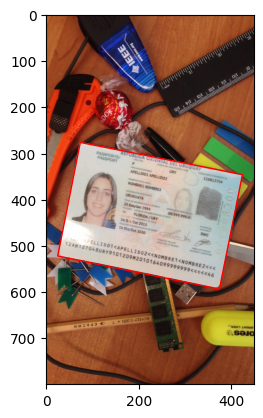

In [18]:
dp[0].show(pred_quad)

In [19]:
results_dict = dict()

for dp in tqdm(data_packs):
    bcm = SimpleBaselineCrop(np.array(dp.template_item.image))
    for i in range(len(dp)):
        if dp[i].is_test_split():
            try:
                results_dict[dp[i].unique_key] = bcm(np.array(dp[i].image))
            except Exception as exc:
                # Для пропущенных в словаре ключей в метриках автоаматически засчитается IoU=0
                print(exc)


  2%|▏         | 1/50 [00:03<02:39,  3.25s/it]

OpenCV(4.9.0) /Users/xperience/GHA-OpenCV-Python2/_work/opencv-python/opencv-python/opencv/modules/calib3d/src/fundam.cpp:385: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'findHomography'

OpenCV(4.9.0) /Users/xperience/GHA-OpenCV-Python2/_work/opencv-python/opencv-python/opencv/modules/calib3d/src/fundam.cpp:385: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'findHomography'

OpenCV(4.9.0) /Users/xperience/GHA-OpenCV-Python2/_work/opencv-python/opencv-python/opencv/modules/calib3d/src/fundam.cpp:385: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'findHomography'

OpenCV(4.9.0) /Users/xperience/GHA-OpenCV-Python2/_work/opencv-python/opencv-python/opencv/modules/calib3d/src/fundam.cpp:385: error: (-28:Unknown error c

  6%|▌         | 3/50 [00:25<06:33,  8.37s/it]

matmul: Input operand 0 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)
OpenCV(4.9.0) /Users/xperience/GHA-OpenCV-Python2/_work/opencv-python/opencv-python/opencv/modules/calib3d/src/fundam.cpp:385: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'findHomography'

matmul: Input operand 0 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)


 18%|█▊        | 9/50 [01:03<03:16,  4.79s/it]

matmul: Input operand 0 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)


 32%|███▏      | 16/50 [01:29<02:07,  3.74s/it]

OpenCV(4.9.0) /Users/xperience/GHA-OpenCV-Python2/_work/opencv-python/opencv-python/opencv/modules/calib3d/src/fundam.cpp:385: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'findHomography'

OpenCV(4.9.0) /Users/xperience/GHA-OpenCV-Python2/_work/opencv-python/opencv-python/opencv/modules/calib3d/src/fundam.cpp:385: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'findHomography'

OpenCV(4.9.0) /Users/xperience/GHA-OpenCV-Python2/_work/opencv-python/opencv-python/opencv/modules/calib3d/src/fundam.cpp:385: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'findHomography'

OpenCV(4.9.0) /Users/xperience/GHA-OpenCV-Python2/_work/opencv-python/opencv-python/opencv/modules/calib3d/src/fundam.cpp:385: error: (-28:Unknown error c

 36%|███▌      | 18/50 [01:54<04:02,  7.57s/it]

OpenCV(4.9.0) /Users/xperience/GHA-OpenCV-Python2/_work/opencv-python/opencv-python/opencv/modules/calib3d/src/fundam.cpp:385: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'findHomography'

OpenCV(4.9.0) /Users/xperience/GHA-OpenCV-Python2/_work/opencv-python/opencv-python/opencv/modules/calib3d/src/fundam.cpp:385: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'findHomography'



 40%|████      | 20/50 [02:01<02:46,  5.55s/it]

OpenCV(4.9.0) /Users/xperience/GHA-OpenCV-Python2/_work/opencv-python/opencv-python/opencv/modules/calib3d/src/fundam.cpp:385: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'findHomography'

OpenCV(4.9.0) /Users/xperience/GHA-OpenCV-Python2/_work/opencv-python/opencv-python/opencv/modules/calib3d/src/fundam.cpp:385: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'findHomography'



 42%|████▏     | 21/50 [02:23<04:56, 10.24s/it]

matmul: Input operand 0 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)
matmul: Input operand 0 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)
OpenCV(4.9.0) /Users/xperience/GHA-OpenCV-Python2/_work/opencv-python/opencv-python/opencv/modules/calib3d/src/fundam.cpp:385: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'findHomography'



 44%|████▍     | 22/50 [02:44<06:20, 13.58s/it]

matmul: Input operand 0 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)


 62%|██████▏   | 31/50 [03:17<01:17,  4.05s/it]

OpenCV(4.9.0) /Users/xperience/GHA-OpenCV-Python2/_work/opencv-python/opencv-python/opencv/modules/calib3d/src/fundam.cpp:385: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'findHomography'



 98%|█████████▊| 49/50 [04:39<00:03,  3.70s/it]

OpenCV(4.9.0) /Users/xperience/GHA-OpenCV-Python2/_work/opencv-python/opencv-python/opencv/modules/calib3d/src/fundam.cpp:385: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'findHomography'



100%|██████████| 50/50 [05:01<00:00,  6.02s/it]


### Сохраним результаты и измерим точность
Результаты - словарь с ключем DataItem.unique_key() и значением предсказанным quadrangle в относительных единицах.

In [20]:
from course_intro_ocr_t1.metrics import dump_results_dict, measure_crop_accuracy

In [21]:
dump_results_dict(results_dict, Path() / 'pred.json')

In [22]:
acc = measure_crop_accuracy(
    Path() / 'pred.json',
    Path() / 'gt.json'
)

In [23]:
print("Точность кропа: {:1.4f}".format(acc))

Точность кропа: 0.9619
